# Example 3: Burgers' problem 

In [57]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

6


In [58]:
# Import module. 
using Revise
using PriorNormalization

In [59]:
# Import packages 
using ApproxFun # for approximating gammainvccdf by a Chbychev interpolant
using CairoMakie # for plots 
using Dates # to measure computational time 
using JLD2 # for saving and loading results
using FlexiMaps # for log-range  
using LinearAlgebra # to represent the identity matrix as "I" 
using Printf # for specific output format
using Random # for generating random noise 
using Statistics  # for mean and quantile
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SparseArrays # for efficient storing of the forward operator 
using SpecialFunctions
using Trixi # for setting up the semi-discretization
using Turing # for setting up the model and sampling 
using Optim # for ML and MAP estimation 
using OrdinaryDiffEq # for time integration
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 

## Burgers' problem: Define the data model 

In [60]:
# Number of equidistant grid points
N = 100

# Select the model i=1,2,3,4 for r=1,1/2,-1/2,-1
model_nr = 4

# Sampler parameters 
MCMC_init = "prior" # Initialization option: "MAP", "prior"
nr_chains = 1 # number of MCMC chains 
nr_samples_raw = 10^6 # Number of samples
thin = 10^2 # Thinning factor

# Problem parameters 
σ² = 1.0*1e-2 # noise variance  
N = 100 # number of points 
M = Int64(ceil(N/5)) # number of observational data 
Random.seed!(123) # Setting the random seed 

TaskLocalRNG()

In [61]:
## Initial data and solution 

# Piecewise constant initial data 
function initial_condition_shock(x, t, equation::InviscidBurgersEquation1D)
    RealT = eltype(x)
    scalar = abs( x[1] - 0.5 ) < 0.25 ? convert(RealT, 1.0f0) : convert(RealT, 0.0f0)

    return SVector(scalar)
end

# Reference solution at time T=0.25 
function ref_solution(x)
    
    N = length(x)
    sol_ref = zeros(N,1) 
    
    for n in 1:N 
        if x[n] >= 0.25 && x[n] < 0.5 
            sol_ref[n] = 4*(x[n] - 0.25) 
        elseif x[n] >= 0.5 && x[n] < 0.875 
            sol_ref[n] = 1
        end
    end

    return sol_ref
end

ref_solution (generic function with 1 method)

In [62]:
## Semidiscretization of the (inviscid) Burgers' equation

equations = InviscidBurgersEquation1D() 

initial_condition = initial_condition_shock

D_upw = upwind_operators(SummationByPartsOperators.Mattsson2017,
                         derivative_order = 1,
                         accuracy_order = 4,
                         xmin = -1.0, xmax = 1.0,
                         N = N)
flux_splitting = splitting_lax_friedrichs
solver = FDSBP(D_upw,
               surface_integral = SurfaceIntegralUpwind(flux_splitting),
               volume_integral = VolumeIntegralUpwind(flux_splitting))

coordinates_min = 0.0
coordinates_max = 1.0
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level = 0,
                n_cells_max = 10_000)

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 1                   │
│ equations: …………………………………………………… InviscidBurgersEquation1D                                        │
│ initial condition: ……………………………… initial_condition_shock                                          │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

In [63]:
## Get the nodal values of the true initial condition and the associated solution 

# Run the simulation 
T = 0.25
tspan = (0.0, T)
ode = semidiscretize(semi, tspan)
sol = solve(ode, SSPRK43())

# Grid points 
grid_u = LinRange(coordinates_min, coordinates_max, N)
grid_b = LinRange(coordinates_min, coordinates_max, M)    

# Extract the initial data  
u0 = sol(0.0) 
# Extract the numerical solution   
uT_num = sol(T)
# Exact solution 
uT_ref = ref_solution(grid_u)

# Generate the observational data 
#obsData_full = uT_num .+ sqrt(σ²)*randn(length(uT_num)) 
obsData_full = uT_ref .+ sqrt(σ²)*randn(length(uT_ref)) 
obsData = obsData_full[1:Int64(ceil(N/M)):end]

20-element Vector{Float64}:
  0.08082879284649669
  0.022981869805186763
  0.12192815097319654
 -0.08900766562698115
  0.20081126248520312
  0.05704871052513616
  0.4023844850955033
  0.28523930705601064
  0.6615987487062823
  0.7074733730284238
  0.8617107722308261
  1.0758746890863273
  0.7474389459416231
  0.8534389143119507
  1.0183639757280603
  1.114809342282114
  1.0566026075396748
  0.957509472426523
 -0.003170723035024594
 -0.06787747615011162

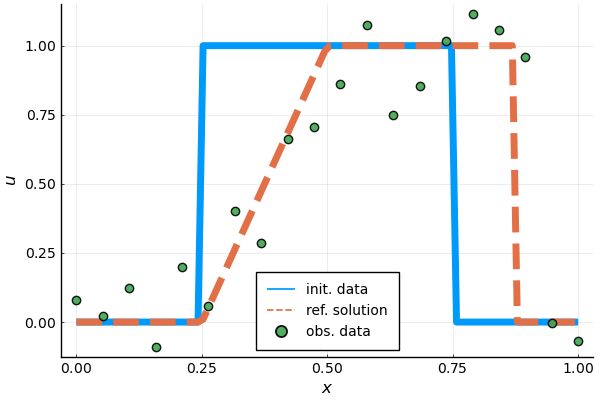

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_dataRef.pdf"

In [64]:
## Plot the init. data, ref. solution, and obs. data 
pd = plot(grid_u, u0, label="init. data", lw=5, ls=:solid)
pd = plot!(grid_u, uT_ref, label="ref. solution", lw=5, ls=:dash)
pd = scatter!(grid_b, obsData, label="obs. data", markersize=6, alpha=0.9)
pd = plot!(pd,  
    #clim=(minimum(u0_fine), maximum(u0_fine)), 
    legend=:bottom, 
    xguide=L"x", yguide=L"u", title="", 
    tickfontsize=10, labelfontsize=12, legendfontsize=10 
)

display(pd);

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_dataRef.pdf"
)
#savefig(output_filename)

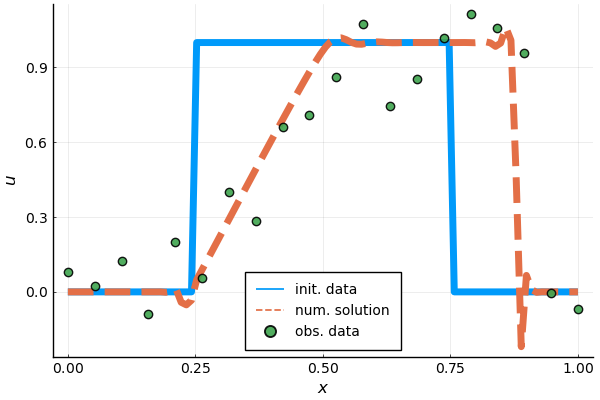

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_dataNum.pdf"

In [65]:
## Plot the init. data, ref. solution, and obs. data 
pd = plot(grid_u, u0, label="init. data", lw=5, ls=:solid)
pd = plot!(grid_u, uT_num, label="num. solution", lw=5, ls=:dash)
pd = scatter!(grid_b, obsData, label="obs. data", markersize=6, alpha=0.9)
pd = plot!(pd,  
    #clim=(minimum(u0_fine), maximum(u0_fine)), 
    legend=:bottom, 
    xguide=L"x", yguide=L"u", title="", 
    tickfontsize=10, labelfontsize=12, legendfontsize=10 
)

display(pd);

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_dataNum.pdf"
)
#savefig(output_filename)

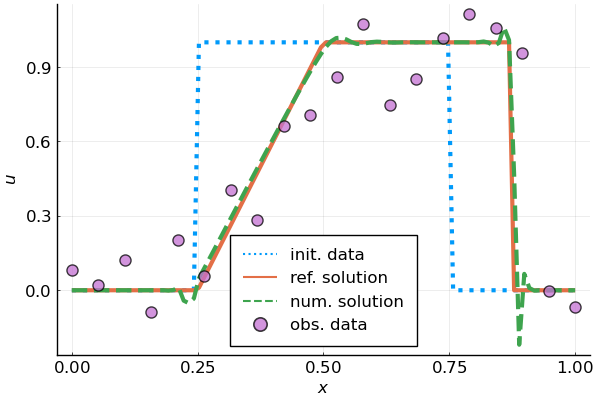

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_data.pdf"

In [ ]:
pyplot()

## Plot the init. data, ref. solution, and obs. data 
pd = plot(grid_u, u0, label="init. data", lw=3, ls=:dot)
pd = plot!(grid_u, uT_ref, label="ref. solution", lw=3, ls=:solid)
pd = plot!(grid_u, uT_num, label="num. solution", lw=3, ls=:dash)
pd = scatter!(grid_b, obsData, label="obs. data", markersize=8, alpha=0.75)
pd = plot!(pd,  
    #clim=(minimum(u0_fine), maximum(u0_fine)), 
    legend=:bottom, 
    xguide=L"x", yguide=L"u", title="", 
    tickfontsize=12, labelfontsize=12, legendfontsize=12 
)

display(pd);

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_data.pdf"
)
#savefig(output_filename)

## The sparsifying transform

In [67]:
# Invertible finite difference matrix
aux = ones(N) * [-1.0, 1.0]'
L = spzeros(Float64, N, N)
L[2:end,:] = spdiagm(0=>-1*ones(N), 1=>ones(N))[1:N-1,1:N]
L[1,1] = 1 

display(L)

# Change coordinates to promote sparsity in v = L*u 
forwardOp( v ) = (1/sqrt(σ²)) * forward_operator( L\v ) 

# Whitening of observational data 
b = (1/sqrt(σ²)) * obsData

100×100 SparseMatrixCSC{Float64, Int64} with 199 stored entries:
⎡⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⎦

20-element Vector{Float64}:
  0.8082879284649669
  0.22981869805186764
  1.2192815097319654
 -0.8900766562698115
  2.008112624852031
  0.5704871052513616
  4.023844850955033
  2.8523930705601064
  6.6159874870628235
  7.074733730284239
  8.617107722308262
 10.758746890863273
  7.474389459416231
  8.534389143119508
 10.183639757280602
 11.14809342282114
 10.56602607539675
  9.57509472426523
 -0.03170723035024594
 -0.6787747615011163

## Select the model

In [68]:
# Parameter of of generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

# We use ApproxFun.jl to build a Chebychev approximation of the function gammainvccdf(β, 1, ⋅) 
interval = Interval(-5, 5)
if r > 0 
    Γinvccdf_cheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdf_cheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

Fun(Chebyshev(-5 .. 5), [4.1893, -6.76855, 3.39898, -0.818537, -0.068503, 0.0574292, 0.0200184, -0.00580982, -0.00554048, -0.000166345  …  -4.223e-10, -9.28847e-10, -2.06209e-10, 2.0424e-10, 1.39925e-10, -1.39843e-11, -4.54018e-11, -1.43472e-11, 1.03344e-11, 6.97238e-12])

## Load and transform the samples

In [69]:
if MCMC_init=="MAP"
    # Original model 
    filename_original = joinpath("data", 
        "Burgers_model$(model_nr)_mcmc_initMAP_AM_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )
    # Prior-normalized model 
    filename_priorNormalized = joinpath("data", 
        "Burgers_model$(model_nr)_mcmc_initMAP_AM_priorNormalized_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

elseif MCMC_init=="prior"
    # Original model 
    filename_original = joinpath(
        "data", 
        "Burgers_model$(model_nr)_mcmc_initPrior_AM_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )
    # Prior-normalized model 
    filename_priorNormalized = joinpath(
        "data", 
        "Burgers_model$(model_nr)_mcmc_initPrior_AM_priorNormalized_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

# Throw an error if none of the available options is provided
else
    error("Invalid initialization option provided: $init. Please choose either 'MAP' or 'prior'.")
end

@load filename_original chn_original wall_duration_original
@load filename_priorNormalized chn_priorNormalized wall_duration_priorNormalized

2-element Vector{Symbol}:
 :chn_priorNormalized
 :wall_duration_priorNormalized

### Tranform the chain for $(v,\theta)$ into a chain for $(u,\theta)$ 

The relation is $v = Lu$

In [70]:
# Initialize an array to store the transformed x vectors

# Array to store the sample values 
nr_samples = size(chn_original.value, 1)
chn_values = Array{Float64}(undef, nr_samples, 2*N, nr_chains)

# Transform v into u
Threads.@threads for j in 1:nr_chains
    for i in 1:nr_samples
        v = chn_original.value[i, 2:2:end, j]
        u = L \ v.data[:]
        chn_values[i, 2:2:end, j] = u
        chn_values[i, 1:2:end-1, j] = chn_original.value[i, 1:2:end-1, j]
    end
end

# Define the parameter names (θ[1], u[1], θ[2], u[2], ...)
param_names_θ = [string("θ[", i, "]") for i in 1:N ]
param_names_u = [string("u[", i, "]") for i in 1:N ]

# Interleave θ and u names
param_names = Vector{String}(undef, 2*N)
param_names[1:2:end] .= param_names_θ
param_names[2:2:end] .= param_names_u

# Create the Chains object
chn_u_original = Chains(chn_values, Symbol.(param_names));

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

### Tranform the chain for $(w,\tau)$ into a chain for $(u,\theta)$

In [71]:
# Initialize an array to store the transformed x vectors

# Array to store the sample values
nr_samples = size(chn_original.value, 1)
chn_values = similar(chn_priorNormalized.value)  

# Change the parameter values 
# Transform each (τ,u) into (θ,x) samples 
Threads.@threads for j in 1:nr_chains
    for i in 1:nr_samples    
        θ = zeros(Float64,N)
        w = zeros(Float64,N)
        v = zeros(Float64,N)
        for n in 1:N 
            τ = chn_priorNormalized.value[i, 2*n-1, j]
            w = chn_priorNormalized.value[i, 2*n, j]
            v[n], θ[n] = priorNormalizing_KR_inv( w, τ; 
                r, β, ϑ, Φ=Γinvccdf_cheb )
        end
        chn_values[i, 1:2:end-1, j] = θ
        u = L \ v
        chn_values[i, 2:2:end, j] = u
    end
end

# Define the parameter names 
param_names_θ = [string("θ[", i, "]") for i in 1:N ]
param_names_u = [string("u[", i, "]") for i in 1:N ]

# Interleave τ and u names
param_names = Vector{String}(undef, 2*N)
param_names[1:2:end] .= param_names_θ
param_names[2:2:end] .= param_names_u

# Create the Chains object
chn_u_priorNormalized = Chains(chn_values, Symbol.(param_names));

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

## Compute different statistics

In [72]:
## Samples from the original posterior 

# Compute statistics for the u-samples
u_mean_original = [mean( get(chn_u_original, :u).u[i] ) for i in 1:N]
#u_std_original = [std( get(chn_u_original, :u).u[i] ) for i in 1:N]
#u_var_original = [var( get(chn_u_original, :u).u[i] ) for i in 1:N]
u_lower_quantile_original = [quantile( vec(get(chn_u_original, :u).u[i]), 0.05 ) for i in 1:N]  # 5% quantile
u_upper_quantile_original = [quantile( vec(get(chn_u_original, :u).u[i]), 0.95 ) for i in 1:N]  # 95% quantile

# Compute statistics for the θ-samples
θ_mean_original = [mean( get(chn_u_original, :θ).θ[i] ) for i in 1:N]
#θ_std_original = [std( get(chn_u_original, :θ).θ[i] ) for i in 1:N]
#θ_var_original = [var( get(chn_u_original, :θ).θ[i] ) for i in 1:N]
θ_lower_quantile_original = [quantile( vec(get(chn_u_original, :θ).θ[i]), 0.05 ) for i in 1:N]  # 5% quantile
θ_upper_quantile_original = [quantile( vec(get(chn_u_original, :θ).θ[i]), 0.95 ) for i in 1:N]  # 95% quantile


## Samples from the prior-normalized posterior 

# Compute statistics for the u-samples
u_mean_priorNormalized = [mean( get(chn_u_priorNormalized, :u).u[i] ) for i in 1:N]
#u_std_priorNormalized = [std( get(chn_u_priorNormalized, :u).u[i] ) for i in 1:N]
#u_var_priorNormalized = [var( get(chn_u_priorNormalized, :u).u[i] ) for i in 1:N]
u_lower_quantile_priorNormalized = [quantile( vec(get(chn_u_priorNormalized, :u).u[i]), 0.05 ) for i in 1:N]  # 5% quantile
u_upper_quantile_priorNormalized = [quantile( vec(get(chn_u_priorNormalized, :u).u[i]), 0.95 ) for i in 1:N]  # 95% quantile

# Compute statistics for the θ-samples
θ_mean_priorNormalized = [mean( get(chn_u_priorNormalized, :θ).θ[i] ) for i in 1:N]
#θ_std_priorNormalized = [std( get(chn_u_priorNormalized, :θ).θ[i] ) for i in 1:N]
#θ_var_priorNormalized = [var( get(chn_u_priorNormalized, :θ).θ[i] ) for i in 1:N]
θ_lower_quantile_priorNormalized = [quantile( vec(get(chn_u_priorNormalized, :θ).θ[i]), 0.05 ) for i in 1:N]  # 5% quantile
θ_upper_quantile_priorNormalized = [quantile( vec(get(chn_u_priorNormalized, :θ).θ[i]), 0.95 ) for i in 1:N]  # 95% quantile

100-element Vector{Float64}:
 0.001986232118327923
 0.001353695235254711
 0.0023125926255979576
 0.002279241566031136
 0.0018710691210564762
 0.0024882339171513087
 0.0024716698384745204
 0.0032318537959338052
 0.0024211525358281607
 0.0025266466572192443
 ⋮
 0.002539545152859365
 0.0017317125633879006
 0.001671339781816682
 0.0032278562653447296
 0.0016859726730068091
 0.004841701855090392
 0.002017164660889807
 0.0019403200812074465
 0.002798948086588835

## Illustrate UQ for the original posterior

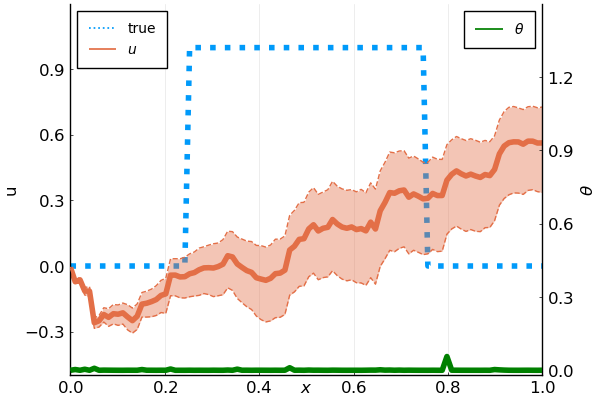

In [ ]:
pyplot() 

# Initiate the plots 
p = plot() 
p_twin = twinx(p) 

# Plot the true signal 
plot!( p, grid_u, u0; 
    label="true", lw=4, ls=:dot )

# Add the pointwise mean for u 
plot!(p, grid_u, u_mean_original; 
    label=L"u", lw=4, ls=:solid )

# Add (invicible) lines for the lower and upper quantiles for u
plot!(p, grid_u, u_lower_quantile_original; 
    label=false, lw=1, ls=:dash, color=2 )
plot!(p, grid_u, u_upper_quantile_original; 
    label=false, lw=1, ls=:dash, color=2 )

# Add shaded region between the quantiles for x 
plot!(p, grid_u, u_lower_quantile_original, 
    fillrange = u_upper_quantile_original, label=false,
    fillalpha = 0.4, lw=0, color=2 )

# Make some cosmetic changes to the plot 
plot!( p, ylabel="u", legend=:topleft,
    xlim = [0, 1], 
    ylim = [-0.5, 1.2], 
    tickfontsize=12, labelfontsize=12, legendfontsize=10 )


# Add the pointwise mean for θ 
plot!(p_twin, grid_u, θ_mean_original; 
    label=L"\theta", lw=4, ls=:solid, color=:green )

# Add (invicible) lines for the lower and upper quantiles for θ
plot!(p_twin, grid_u, θ_lower_quantile_original;
    label=false, lw=1, ls=:dash, color=:green )
plot!(p_twin, grid_u, θ_upper_quantile_original; 
    label=false, lw=1, ls=:dash, color=:green )

# Add shaded region between the quantiles for θ 
plot!(p_twin, grid_u, θ_lower_quantile_original, 
    fillrange = θ_upper_quantile_original, label=false, 
    fillalpha = 0.4, lw=0, color=:green )

# Make some cosmetic changes to the plot 
plot!( p_twin, xlabel=L"x", ylabel=L"\theta", legend=:topright, 
    xlim = [0, 1], 
    ylim = [-2e-2, 1.5], 
    #ylim = [-1e-3, 0.2],
    tickfontsize=12, labelfontsize=12, legendfontsize=10 )

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_model$(model_nr)_UQquantile_original_AM_$(MCMC_init).pdf"
)
#PyPlot.savefig(output_filename)

## Illustrate UQ for the prior-normalized posterior

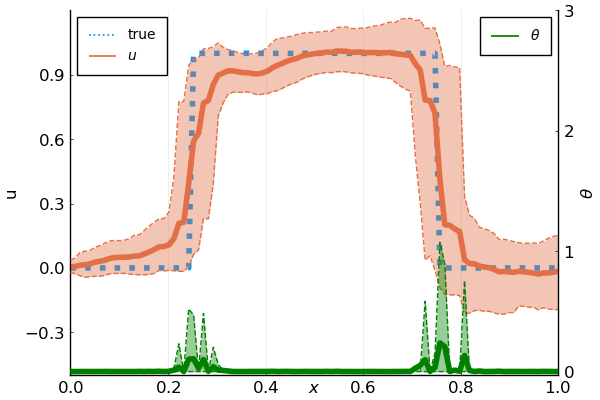

In [ ]:
pyplot() 

# Initiate the plots 
p = plot() 
p_twin = twinx(p) 

# Plot the true signal 
plot!( p, grid_u, u0; 
    label="true", lw=4, ls=:dot )

# Add the pointwise mean for u 
plot!(p, grid_u, u_mean_priorNormalized; 
    label=L"u", lw=4, ls=:solid )

# Add (invicible) lines for the lower and upper quantiles for u
plot!(p, grid_u, u_lower_quantile_priorNormalized; 
    label=false, lw=1, ls=:dash, color=2 )
plot!(p, grid_u, u_upper_quantile_priorNormalized; 
    label=false, lw=1, ls=:dash, color=2 )

# Add shaded region between the quantiles for x 
plot!(p, grid_u, u_lower_quantile_priorNormalized, 
    fillrange = u_upper_quantile_priorNormalized, label=false,
    fillalpha = 0.4, lw=0, color=2 )

# Make some cosmetic changes to the plot 
plot!( p, ylabel="u", legend=:topleft,
    xlim = [0, 1], 
    ylim = [-0.5, 1.2], 
    tickfontsize=12, labelfontsize=12, legendfontsize=10 )


# Add the pointwise mean for θ 
plot!(p_twin, grid_u, θ_mean_priorNormalized; 
    label=L"\theta", lw=4, ls=:solid, color=:green )

# Add (invicible) lines for the lower and upper quantiles for θ
plot!(p_twin, grid_u, θ_lower_quantile_priorNormalized;
    label=false, lw=1, ls=:dash, color=:green )
plot!(p_twin, grid_u, θ_upper_quantile_priorNormalized; 
    label=false, lw=1, ls=:dash, color=:green )

# Add shaded region between the quantiles for θ 
plot!(p_twin, grid_u, θ_lower_quantile_priorNormalized, 
    fillrange = θ_upper_quantile_priorNormalized, label=false, 
    fillalpha = 0.4, lw=0, color=:green )

# Make some cosmetic changes to the plot 
plot!( p_twin, xlabel=L"x", ylabel=L"\theta", legend=:topright, 
    xlim = [0, 1], 
    ylim = [-3e-2, 3], 
    #ylim = [-1e-3, 0.2],
    tickfontsize=12, labelfontsize=12, legendfontsize=10 )

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_model$(model_nr)_UQquantile_priorNormalized_AM_$(MCMC_init).pdf"
)
#PyPlot.savefig(output_filename)

## Plot different samples from original posterior

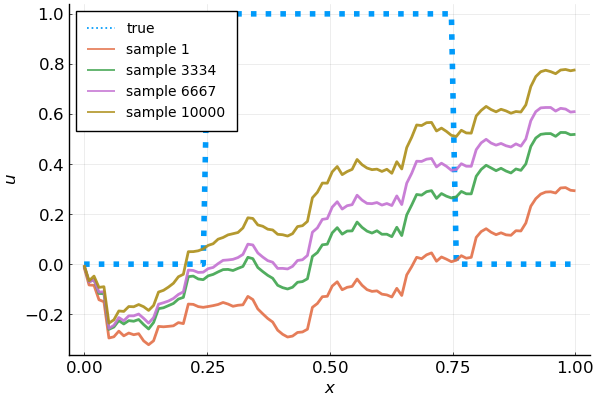

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_model4_uSamples_original_AM_prior.pdf"

In [75]:
# Select sub-chains 
nr_draws = 4 
I_all = size(chn_u_original, 1)
selected_indices = collect(Int64.(range(1, I_all, length=nr_draws))) 

pyplot()

# Initiate the plots 
p = plot() 

# Plot the true signal 
Plots.plot!( p, grid_u, u0; label="true", lw=4, ls=:dot )

# Plot four samples for u
for i in 1:nr_draws
    chn_selected = chn_u_original[selected_indices[i], :, 1]
    u_samples = [mean( get(chn_selected, :u).u[n] ) for n in 1:N]
    plot!(p, grid_u, u_samples; lw=2, ls=:solid, alpha=.9, 
        label="sample $(selected_indices[i])" )
end

# Make some cosmetic changes to the plot 
plot!( p, xlabel=L"x", ylabel=L"u", legend=:topleft, 
    #ylim = [-3.5, 1.75], 
    tickfontsize=12, labelfontsize=12, legendfontsize=10 )

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_model$(model_nr)_uSamples_original_AM_$(MCMC_init).pdf"
)
#PyPlot.savefig(output_filename)

## Plot different samples from prior-normalized posterior

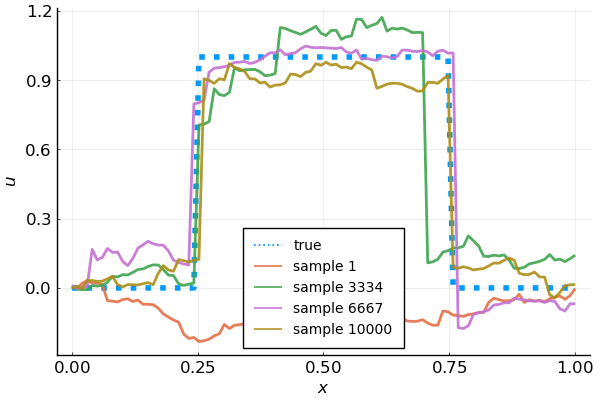

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_model4_uSamples_priorNormalized_AM_prior.pdf"

In [76]:
# Select sub-chains 
nr_draws = 4 
I_all = size(chn_u_priorNormalized, 1)
selected_indices = collect(Int64.(range(1, I_all, length=nr_draws))) 

pyplot()

# Initiate the plots 
p = plot() 

# Plot the true signal 
Plots.plot!( p, grid_u, u0; label="true", lw=4, ls=:dot )

# Plot four samples for u
for i in 1:nr_draws
    chn_selected = chn_u_priorNormalized[selected_indices[i], :, 1]
    u_samples = [mean( get(chn_selected, :u).u[n] ) for n in 1:N]
    plot!(p, grid_u, u_samples; lw=2, ls=:solid, alpha=.9, 
        label="sample $(selected_indices[i])" )
end

# Make some cosmetic changes to the plot 
plot!( p, xlabel=L"x", ylabel=L"u", legend=:bottom, 
    #ylim = [-3.5, 1.75], 
    tickfontsize=12, labelfontsize=12, legendfontsize=10 )

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_model$(model_nr)_uSamples_priorNormalized_AM_$(MCMC_init).pdf"
)
#PyPlot.savefig(output_filename)

## Traces at two different locations location

We focus on investigating  $u[j]$ for $j=25$ and $j=50$.
Note that $t[j] \approx 0.25$ and $u_{\rm true}[j] = 0$ for $j=25$, which is close to the first jump discontinuity.
Furthermore, $t[j] \approx 0.5$ and $x_{\rm true}[j] = 1$ for $j=50$, which lies in a constant region.

In [77]:
# Extract samples from the original and prior-normalized posterior 

# Fix indices 
j1 = 26 # first index 
j2 = 50 # second index 

# Extract samples from original posterior
u_original_j1 = get(chn_u_original, :u).u[j1];
u_original_j2 = get(chn_u_original, :u).u[j2];

# Extract samples from prior-normalized posterior
u_priorNormalized_j1 = get(chn_u_priorNormalized, :u).u[j1];
u_priorNormalized_j2 = get(chn_u_priorNormalized, :u).u[j2];

# True value 
u_true_j1 = u0[j1]*ones(length(u_original_j1) , 1);
u_true_j2 = u0[j2]*ones(length(u_original_j2) , 1);

In [84]:
grid_u = LinRange(coordinates_min, coordinates_max, N)
grid_u[26]

0.25252525252525254

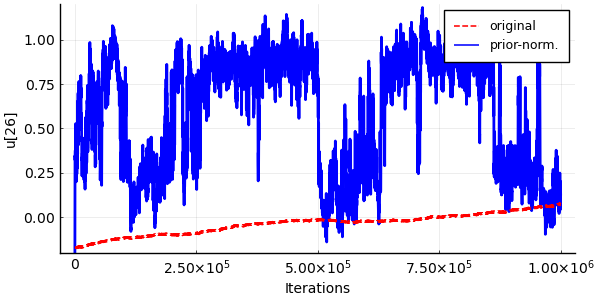

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_model4_traces_u26_AM_prior.pdf"

In [ ]:
# Generate figure
Plots.pyplot()

# True value 
#p = StatsPlots.plot( 1:thin:nr_samples_raw, u_true_j1; 
#    lw=2, label="true", color="green" )

# Original posterior 
p = StatsPlots.plot( 1:thin:nr_samples_raw, u_original_j1; 
    lw=2, ls=:dash, color="red", label="original" )

# Original posterior 
StatsPlots.plot!( p, 1:thin:nr_samples_raw, u_priorNormalized_j1; 
    lw=2, color="blue", label="prior-norm." )

StatsPlots.plot!( p, 1:thin:nr_samples_raw, u_original_j1; 
    lw=2, ls=:dash, color="red", label="" )

# Make some cosmetic changes to the plot 
StatsPlots.plot!( p, 
    ylim = [-0.2, 1.2],
    xlabel="Iterations", ylabel="u[26]", 
    tickfontsize=10, labelfontsize=10, legendfontsize=9, 
    legend=:topright, size=(600,300) 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/Burgers_model$(model_nr)_traces_u26_AM_$(MCMC_init).pdf")
#savefig(output_filename)

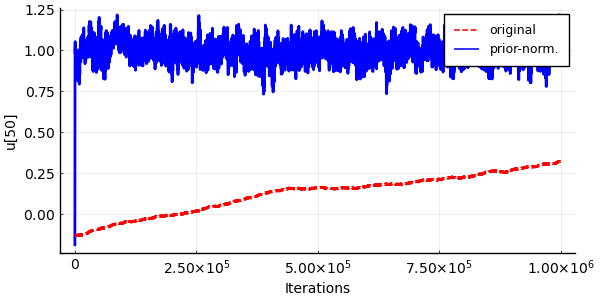

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_model4_traces_u50_AM_prior.pdf"

In [79]:
# Generate figure
Plots.pyplot()

# True value 
#p = StatsPlots.plot( 1:thin:nr_samples_raw, u_true_j2; 
#    lw=2, label="true", color="green" )

# Original posterior 
p = StatsPlots.plot( 1:thin:nr_samples_raw, u_original_j2; 
    lw=2, ls=:dash, color="red", label="original" )

# Original posterior 
StatsPlots.plot!( p, 1:thin:nr_samples_raw, u_priorNormalized_j2; 
    lw=2, color="blue", label="prior-norm." )

StatsPlots.plot!( p, 1:thin:nr_samples_raw, u_original_j2; 
    lw=2, ls=:dash, color="red", label="" )

# Make some cosmetic changes to the plot 
StatsPlots.plot!( p, 
    #ylim = [-0.2, 1.2],
    xlabel="Iterations", ylabel="u[50]", 
    tickfontsize=10, labelfontsize=10, legendfontsize=9, 
    size=(600,300), 
    #legend=:topright 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/Burgers_model$(model_nr)_traces_u50_AM_$(MCMC_init).pdf")
#savefig(output_filename)

## Marginal densities at two different locations location

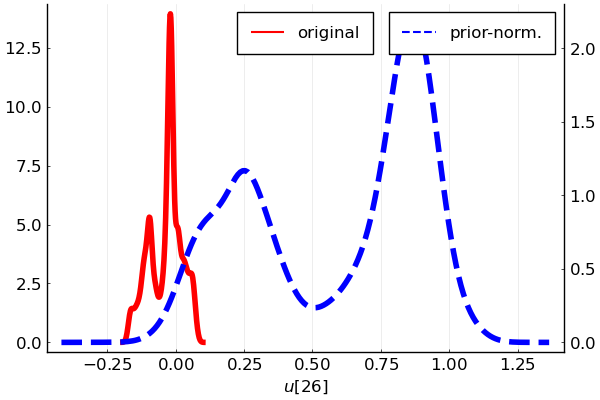

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_model4_densities_u26_AM_prior.pdf"

In [80]:
# Generate figure
Plots.pyplot()

# Initiate the plots 
p = plot() 
p_twin = twinx(p)

# Density for original samples 
StatsPlots.density!( p, u_original_j1[:];
    label="original", lw=4, ls=:solid, color=:red )

# Make some cosmetic changes to the plot 
plot!( p, xlabel=L"u[26]", legend=:top, #xlim=[-.2,.2], 
    tickfontsize=12, labelfontsize=12, legendfontsize=12 )

# Density for prior-normalized samples 
StatsPlots.density!( p_twin, u_priorNormalized_j1[:];
    label="prior-norm.", lw=4, ls=:dash, color=:blue )

# Make some cosmetic changes to the plot 
plot!( p_twin, xlabel="", legend=:topright, #xlim=[-.2,.2], 
    tickfontsize=12, labelfontsize=12, legendfontsize=12 )

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_model$(model_nr)_densities_u26_AM_$(MCMC_init).pdf"
)
#PyPlot.savefig(output_filename)

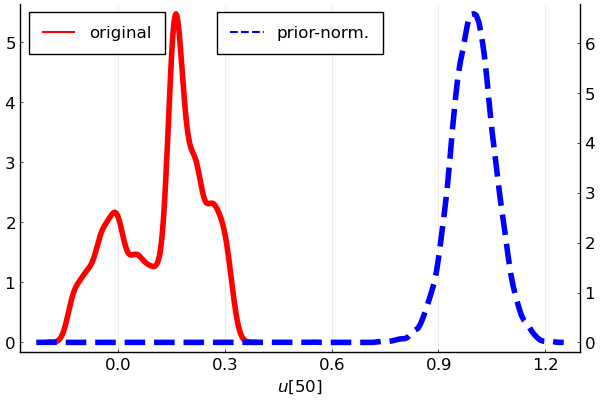

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_model4_densities_u50_AM_prior.pdf"

In [81]:
# Generate figure
Plots.pyplot()

# Initiate the plots 
p = plot() 
p_twin = twinx(p)

# Density for original samples 
StatsPlots.density!( p, u_original_j2[:];
    label="original", lw=4, ls=:solid, color=:red )

# Make some cosmetic changes to the plot 
plot!( p, xlabel=L"u[50]", legend=:topleft, #xlim=[-.0,1.5], 
    tickfontsize=12, labelfontsize=12, legendfontsize=12 )

# Density for prior-normalized samples 
StatsPlots.density!( p_twin, u_priorNormalized_j2[:];
    label="prior-norm.", lw=4, ls=:dash, color=:blue )

# Make some cosmetic changes to the plot 
plot!( p_twin, xlabel="", legend=:top, #xlim=[-.2,.2], 
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    forground_color_legend = nothing )

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_model$(model_nr)_densities_u50_AM_$(MCMC_init).pdf"
)
#PyPlot.savefig(output_filename)